In [1]:
import numpy as np
import gdal
import matplotlib.pyplot as plt
import os
import pandas as pd
import datetime
import bisect
import functools
# from multiprocessing import Pool
import itertools
import pickle as pkl
%matplotlib inline

In [2]:
# read all band images in a directory
images = {}
image_dir = 'earthengine_images/'
for fn in os.listdir(image_dir):
    raw = gdal.Open(image_dir + fn)
    arr = raw.ReadAsArray()
    images[fn.split('.')[0]] = arr

In [4]:
# read all mask images in a directory
masks = {}
mask_dir = 'earthengine_masks/'
for fn in os.listdir(mask_dir):
    raw = gdal.Open(mask_dir + fn)
    arr = raw.ReadAsArray()
    masks[fn.split('.')[0]] = arr

In [5]:
# compose band and mask images into one image
combined = {}
image_dir = 'earthengine_images/'
mask_dir = 'earthengine_masks/'
for fn in os.listdir(image_dir):
    raw_img = gdal.Open(image_dir + fn)
    arr_img = raw_img.ReadAsArray()
    raw_msk = gdal.Open(mask_dir + fn)
    arr_msk = raw_msk.ReadAsArray()
    combined[fn.split('.')[0]] = np.concatenate((arr_img, arr_msk), axis=0)

In [6]:
# use image names to look up metadata from csv export
table = pd.read_csv('earthengine_tables/LC8_SR.csv')
time_start = table[['system:index', 'system:time_start']]

In [7]:
# compose all data into a single data frame
ds = {}
for k, v in combined.items():
    ts = time_start[time_start['system:index'] == k]['system:time_start'].iloc[0]
    ds[ts] = v

In [8]:
ds.keys()

dict_keys([1440634536577, 1432340092546, 1459382957827, 1445558982533, 1458000568200, 1433117325195, 1435882143244, 1442016943362, 1428192911630, 1433722502125, 1426205354132, 1453853382683, 1424822966175, 1442794176672, 1449706184998, 1448928958023, 1452470982577, 1454458551604, 1450311357239, 1429575310943, 1436487319228, 1441411768125, 1424045737534, 1427587746370, 1451088586307, 1430352533188, 1448323787335, 1438646955592, 1440029363213, 1426810523472, 1434499736147, 1447546555861, 1444781749463, 1435104908414, 1458605735131, 1423440571231, 1446164155488, 1451693755106, 1430957695975, 1446941385063, 1444176579436, 1457223342061, 1437869725294, 1455235776496, 1456618171987, 1431734919028, 1439252129269, 1443399349500, 1437264552573, 1453076154238])

Alternative flow:

In [46]:
def get_boolean_mask(image, level=1):
    cfmask = image[3, :, :]
    cfmask_conf = image[4, :, :]
    return (cfmask == 0) & (cfmask_conf <= level)

In [70]:
def zigzag_integer_pairs(max_x, max_y):
    total = 0
    x = 0
    while total <= max_x + max_y:
        if total - x <= max_y:
            yield (x, total - x)
        if x <= min(max_x - 1, total - 1):
            x += 1
        else:
            total += 1
            x = 0

In [72]:
print([x for x in zigzag_integer_pairs(3,5)])

[(0, 0), (0, 1), (1, 0), (0, 2), (1, 1), (2, 0), (0, 3), (1, 2), (2, 1), (3, 0), (0, 4), (1, 3), (2, 2), (3, 1), (0, 5), (1, 4), (2, 3), (3, 2), (1, 5), (2, 4), (3, 3), (2, 5), (3, 4), (3, 5)]


In [133]:
def interpolate(timestamp, dataset):
    times = list(dataset.keys())
    times.sort()
    pos = bisect.bisect(times, timestamp)
    n_times = len(times)
    dims = dataset[times[0]].shape
    interpolated = np.zeros((3, *dims[1:]))
    times_before = times[:pos]
    times_before.reverse()
    times_after = times[pos:]
    unfilled = np.ones(dims[1:], dtype=bool)
    for pair in zigzag_integer_pairs(len(times_before) - 1, len(times_after) - 1):
        before = times_before[pair[0]]
        after = times_after[pair[1]]
        alpha = 1.0 * (timestamp - before) / (after - before)
        mask_before = get_boolean_mask(dataset[before])
        mask_after = get_boolean_mask(dataset[after])
        common_unmasked = mask_before & mask_after
        valid = common_unmasked & unfilled
#         fitted = dataset[before][:3, :, :] * alpha + dataset[after][:3, :, :] * (1 - alpha)
        fitted = np.zeros((3, *dims[1:]))
        fitted[:, valid] = dataset[before][:3, valid] * alpha + dataset[after][:3, valid] * (1 - alpha)
        unfilled = unfilled ^ valid
        interpolated[:, valid] = fitted[:, valid]
    return interpolated

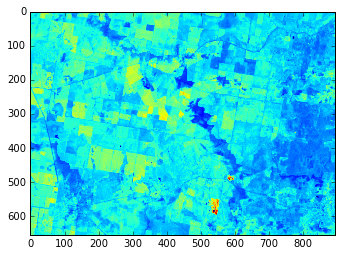

In [134]:
mid = int((1450311357239 + 1452470982577) / 2)
res = interpolate(mid, ds)
plt.imshow(res[0, :, :])
plt.show()